# Multi-Method Token Attribution Comparison

This notebook compares multiple interpretability methods for the DistilBERT + MLP hyperpartisan news classifier.

**Methods implemented:**
- Integrated Gradients (IG)
- Integrated Gradients × Input
- Gradient (Saliency)
- Gradient × Input
- LIME
- Partition SHAP

In [17]:
import sys
from pathlib import Path

# Ensure project root is in path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import warnings
warnings.filterwarnings('ignore')

In [18]:
from transformer.interpret_compare import (
    MultiMethodAttributor,
    load_model,
    load_tokenizer,
    get_device,
    style_comparison_table,
    plot_comparison_heatmaps,
)

print("Modules loaded successfully")

Modules loaded successfully


## 1. Load Model and Tokenizer

In [19]:
# Use CPU for stability with gradient computations
# Change to 'mps' or 'cuda' for faster inference
device = get_device('cpu')
print(f"Using device: {device}")

model = load_model()
tokenizer = load_tokenizer()

print("Model loaded successfully")

Using device: cpu
Using fold 3 (F1=0.8846)
Model loaded successfully


In [20]:
# Initialize attributor
attributor = MultiMethodAttributor(
    model=model,
    tokenizer=tokenizer,
    device=device,
    n_steps=50,  # Increase for higher precision IG
)

print(f"Available methods: {attributor.METHODS}")

Available methods: ['Integrated Gradients', 'Integrated Gradients × Input', 'Gradient', 'Gradient × Input', 'LIME', 'Partition SHAP']


## 2. Example: Analyze Sample Text

In [21]:
# Example text - replace with your own
sample_text = "The corrupt politicians are destroying our country with their radical socialist agenda."

print(f"Analyzing: {sample_text}")

Analyzing: The corrupt politicians are destroying our country with their radical socialist agenda.


In [22]:
# Compute attributions using all methods
# Note: LIME and SHAP can be slow on longer texts
df, prediction = attributor.compute_all(
    text=sample_text,
    lime_samples=300,  # Reduce for faster execution
    shap_evals=300,
)

print(f"\nPrediction: P(hyperpartisan) = {prediction:.3f}")
print(f"Classification: {'Hyperpartisan' if prediction > 0.5 else 'Mainstream'}")


Prediction: P(hyperpartisan) = 0.280
Classification: Mainstream


## 3. Comparison Table

In [23]:
# Display styled comparison table
# Red = contributes to hyperpartisan, Blue = contributes to mainstream
style_comparison_table(df)

,the,corrupt,politicians,are,destroying,our,country,with,their,radical,socialist,agenda,.
Integrated Gradients,-0.21,0.07,0.20,0.14,-0.08,0.16,0.33,0.09,0.06,0.20,0.35,0.15,1.00
Integrated Gradients × Input,0.15,-0.23,-0.18,0.29,-0.17,-0.02,-0.47,0.02,0.11,-0.28,0.03,-0.24,1.00
Gradient,0.29,0.93,-0.14,-0.64,0.62,1.00,-0.11,0.25,-0.70,0.23,-0.11,-0.07,0.18
Gradient × Input,-0.56,0.21,0.29,-0.56,-0.24,-0.58,-0.26,-0.27,-1.00,0.49,0.44,-0.08,0.04
LIME,-0.43,0.43,1.00,-0.41,0.41,0.12,0.03,-0.39,-0.21,0.15,0.70,0.00,0.00
Partition SHAP,-0.01,0.79,0.61,0.68,0.43,0.51,1.00,0.58,0.35,0.37,0.31,0.54,0.53


## 4. Heatmap Visualization

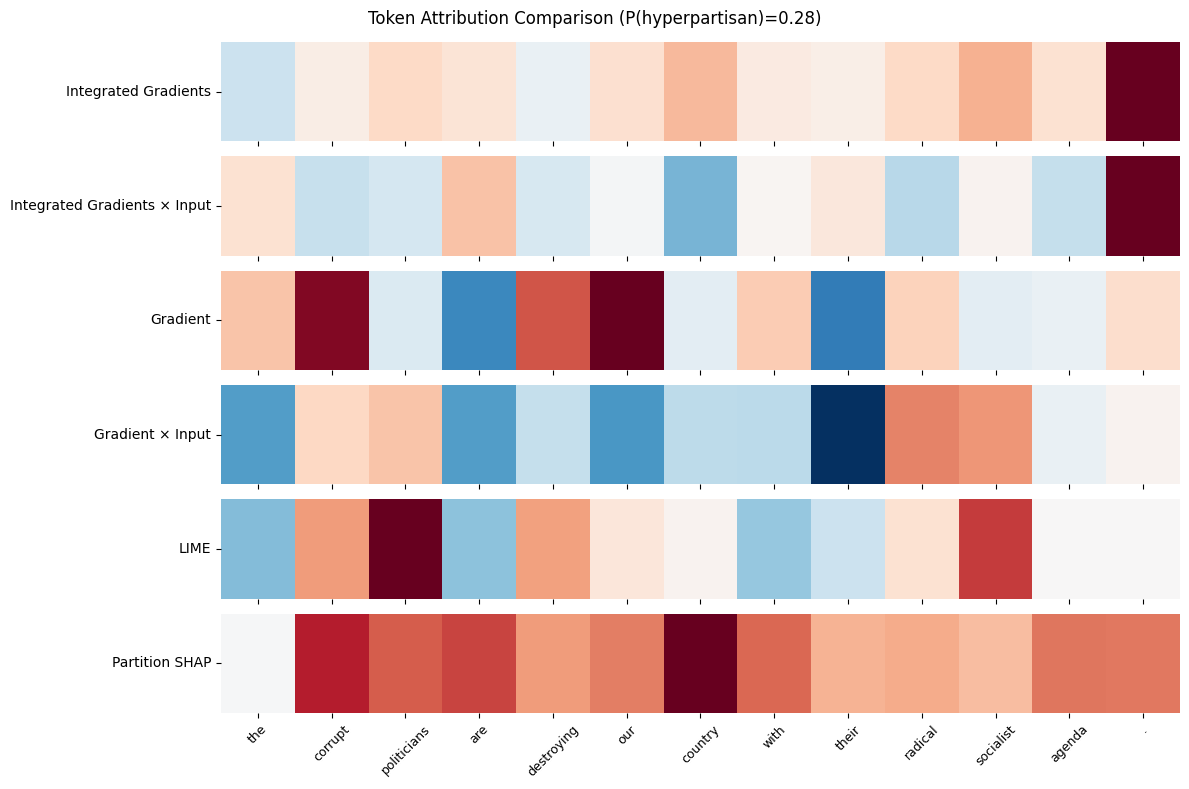

In [24]:
import matplotlib.pyplot as plt

fig = plot_comparison_heatmaps(df, prediction, figsize=(12, 8))
plt.show()

## 5. Quick Comparison (Gradient Methods Only)

For faster iteration, run only the Captum-based gradient methods:

In [25]:
quick_methods = [
    "Integrated Gradients",
    "Integrated Gradients × Input",
    "Gradient",
    "Gradient × Input",
]

df_quick, pred = attributor.compute_all(
    text=sample_text,
    methods=quick_methods,
)

style_comparison_table(df_quick)

,the,corrupt,politicians,are,destroying,our,country,with,their,radical,socialist,agenda,.
Integrated Gradients,-0.21,0.07,0.20,0.14,-0.08,0.16,0.33,0.09,0.06,0.20,0.35,0.15,1.00
Integrated Gradients × Input,0.15,-0.23,-0.18,0.29,-0.17,-0.02,-0.47,0.02,0.11,-0.28,0.03,-0.24,1.00
Gradient,0.29,0.93,-0.14,-0.64,0.62,1.00,-0.11,0.25,-0.70,0.23,-0.11,-0.07,0.18
Gradient × Input,-0.56,0.21,0.29,-0.56,-0.24,-0.58,-0.26,-0.27,-1.00,0.49,0.44,-0.08,0.04


## 6. Analyze Article from Dataset

In [26]:
from preprocess import load_cached_data

# Load test articles
test_data = load_cached_data('test_byarticle')
print(f"Loaded {len(test_data)} test articles")

# Show sample articles
for i, article in enumerate(test_data[:5]):
    label = 'Hyperpartisan' if article['label'] == 1 else 'Mainstream'
    preview = article['text'][:80] + '...'
    print(f"{i}: [{label}] {article['id']}: {preview}")

Loaded 628 test articles
0: [Mainstream] 0000645: breaking bomb squad dispatched for suspicious device found in downtown evansvill...
1: [Hyperpartisan] 0000646: the crazy republican endorsed logic behind if trump loses i m grabbing my musket...
2: [Mainstream] 0000647: review of emails in weiner s laptop for potential clinton ties could take weeks ...
3: [Hyperpartisan] 0000648: trump s astounding hypocritical cruelty peaks with alicia machado sex tape tweet...
4: [Hyperpartisan] 0000649: max boot republicans have stockholm syndrome and it s getting worse president do...


In [27]:
# Analyze a specific article (use first 200 tokens for speed)
article_idx = 0
article = test_data[article_idx]

# Truncate for faster analysis
text_sample = ' '.join(article['text'].split()[:100])

print(f"Article ID: {article['id']}")
print(f"True label: {'Hyperpartisan' if article['label'] == 1 else 'Mainstream'}")
print(f"Text preview: {text_sample[:200]}...")

Article ID: 0000645
True label: Mainstream
Text preview: breaking bomb squad dispatched for suspicious device found in downtown evansville according to evansville watch the epd amp the bomb squad have been dispatched to downtown evansville after a suspiciou...


In [28]:
# Run quick gradient-based comparison
df_article, pred_article = attributor.compute_all(
    text=text_sample,
    methods=quick_methods,
)

print(f"Prediction: P(hyperpartisan) = {pred_article:.3f}")
style_comparison_table(df_article)

Prediction: P(hyperpartisan) = 0.021


KeyError: '`Styler.apply` and `.map` are not compatible with non-unique index or columns.'

## 7. Method Agreement Analysis

In [29]:
import numpy as np
from scipy.stats import spearmanr

def compute_method_correlations(df):
    """Compute pairwise Spearman correlations between methods."""
    methods = df.index.tolist()
    n = len(methods)
    corr_matrix = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            corr, _ = spearmanr(df.iloc[i].values, df.iloc[j].values)
            corr_matrix[i, j] = corr
    
    return pd.DataFrame(corr_matrix, index=methods, columns=methods)

# Compute correlations
corr_df = compute_method_correlations(df)

# Display as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, fmt='.2f', cmap='coolwarm', center=0, vmin=-1, vmax=1)
plt.title('Method Agreement (Spearman Correlation)')
plt.tight_layout()
plt.show()

NameError: name 'pd' is not defined

## 8. Save Results

In [ ]:
# Save comparison table to HTML
output_dir = Path('../output')
output_dir.mkdir(exist_ok=True)

styled = style_comparison_table(df)
styled.to_html(output_dir / 'attribution_comparison.html')

# Save raw data to CSV
df.to_csv(output_dir / 'attribution_comparison.csv')

print(f"Results saved to {output_dir}")